In [1]:
import cira

cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

In [3]:
SYMBOL = "INTC"
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

ast = cira.Stock(SYMBOL)


if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2000, 1, 1)
    end = datetime.now().date() 
    ast.save_historical_data(SYM_HIST_FILE, start, end)

data = ast.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,INTC,26.96,27.06,26.62,27.05,32165978.0,122840.0,26.88
2016-01-05 05:00:00+00:00,INTC,27.02,27.05,26.68,26.92,17905707.0,87505.0,26.85
2016-01-06 05:00:00+00:00,INTC,26.46,26.67,26.10,26.32,26939523.0,121984.0,26.39
2016-01-07 05:00:00+00:00,INTC,25.68,26.26,25.33,25.33,41368839.0,163862.0,25.63
2016-01-08 05:00:00+00:00,INTC,25.53,25.64,25.01,25.07,32404640.0,142641.0,25.31


<Axes: xlabel='timestamp'>

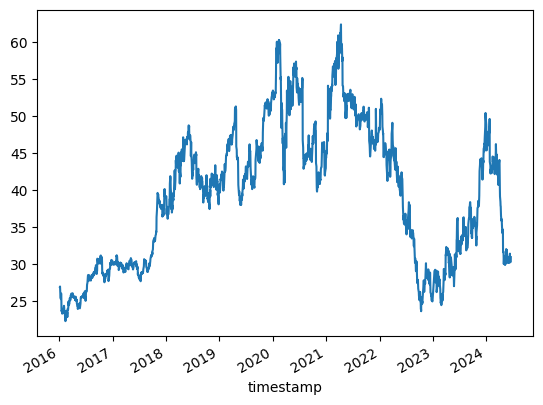

In [4]:
data["open"].plot()

<Axes: xlabel='timestamp'>

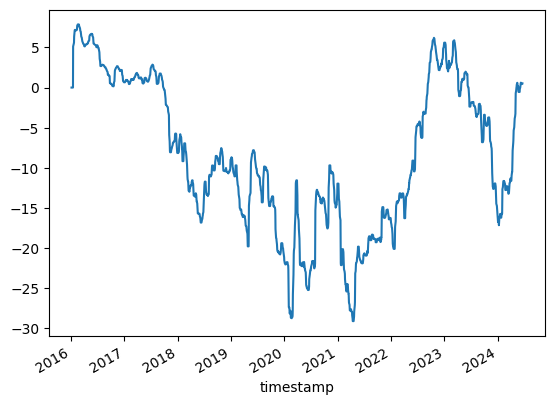

In [5]:

data["diff"] = (data["open"].values[-1] - data["open"]).rolling(10).median()
data["diff"] = data["diff"].fillna(0)
data["diff"].plot()

In [6]:
classes = {
    "nueatral": 0,
    "light_buy": 1,
    "light_sell": 2,
    "hard_buy": 3,
    "hard_sell":4,
}

<Axes: xlabel='signal'>

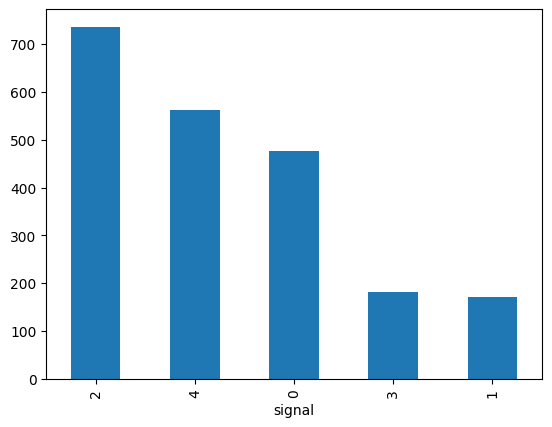

In [7]:
data["signal"] = classes["nueatral"]
data.loc[data["diff"] > 2, "signal"] = classes["light_buy"]
data.loc[data["diff"] < -5, "signal"] = classes["light_sell"]
data.loc[data["diff"] > 4, "signal"] = classes["hard_buy"]
data.loc[data["diff"] < -15, "signal"] = classes["hard_sell"]
data["signal"].value_counts().plot.bar()

In [8]:
data.drop(columns=["symbol"], inplace=True)
data.head()

,open,high,low,close,volume,trade_count,vwap,diff,signal
timestamp,,,,,,,,,
2016-01-04 05:00:00+00:00,26.96,27.06,26.62,27.05,32165978.0,122840.0,26.88,0.0,0
2016-01-05 05:00:00+00:00,27.02,27.05,26.68,26.92,17905707.0,87505.0,26.85,0.0,0
2016-01-06 05:00:00+00:00,26.46,26.67,26.10,26.32,26939523.0,121984.0,26.39,0.0,0
2016-01-07 05:00:00+00:00,25.68,26.26,25.33,25.33,41368839.0,163862.0,25.63,0.0,0
2016-01-08 05:00:00+00:00,25.53,25.64,25.01,25.07,32404640.0,142641.0,25.31,0.0,0


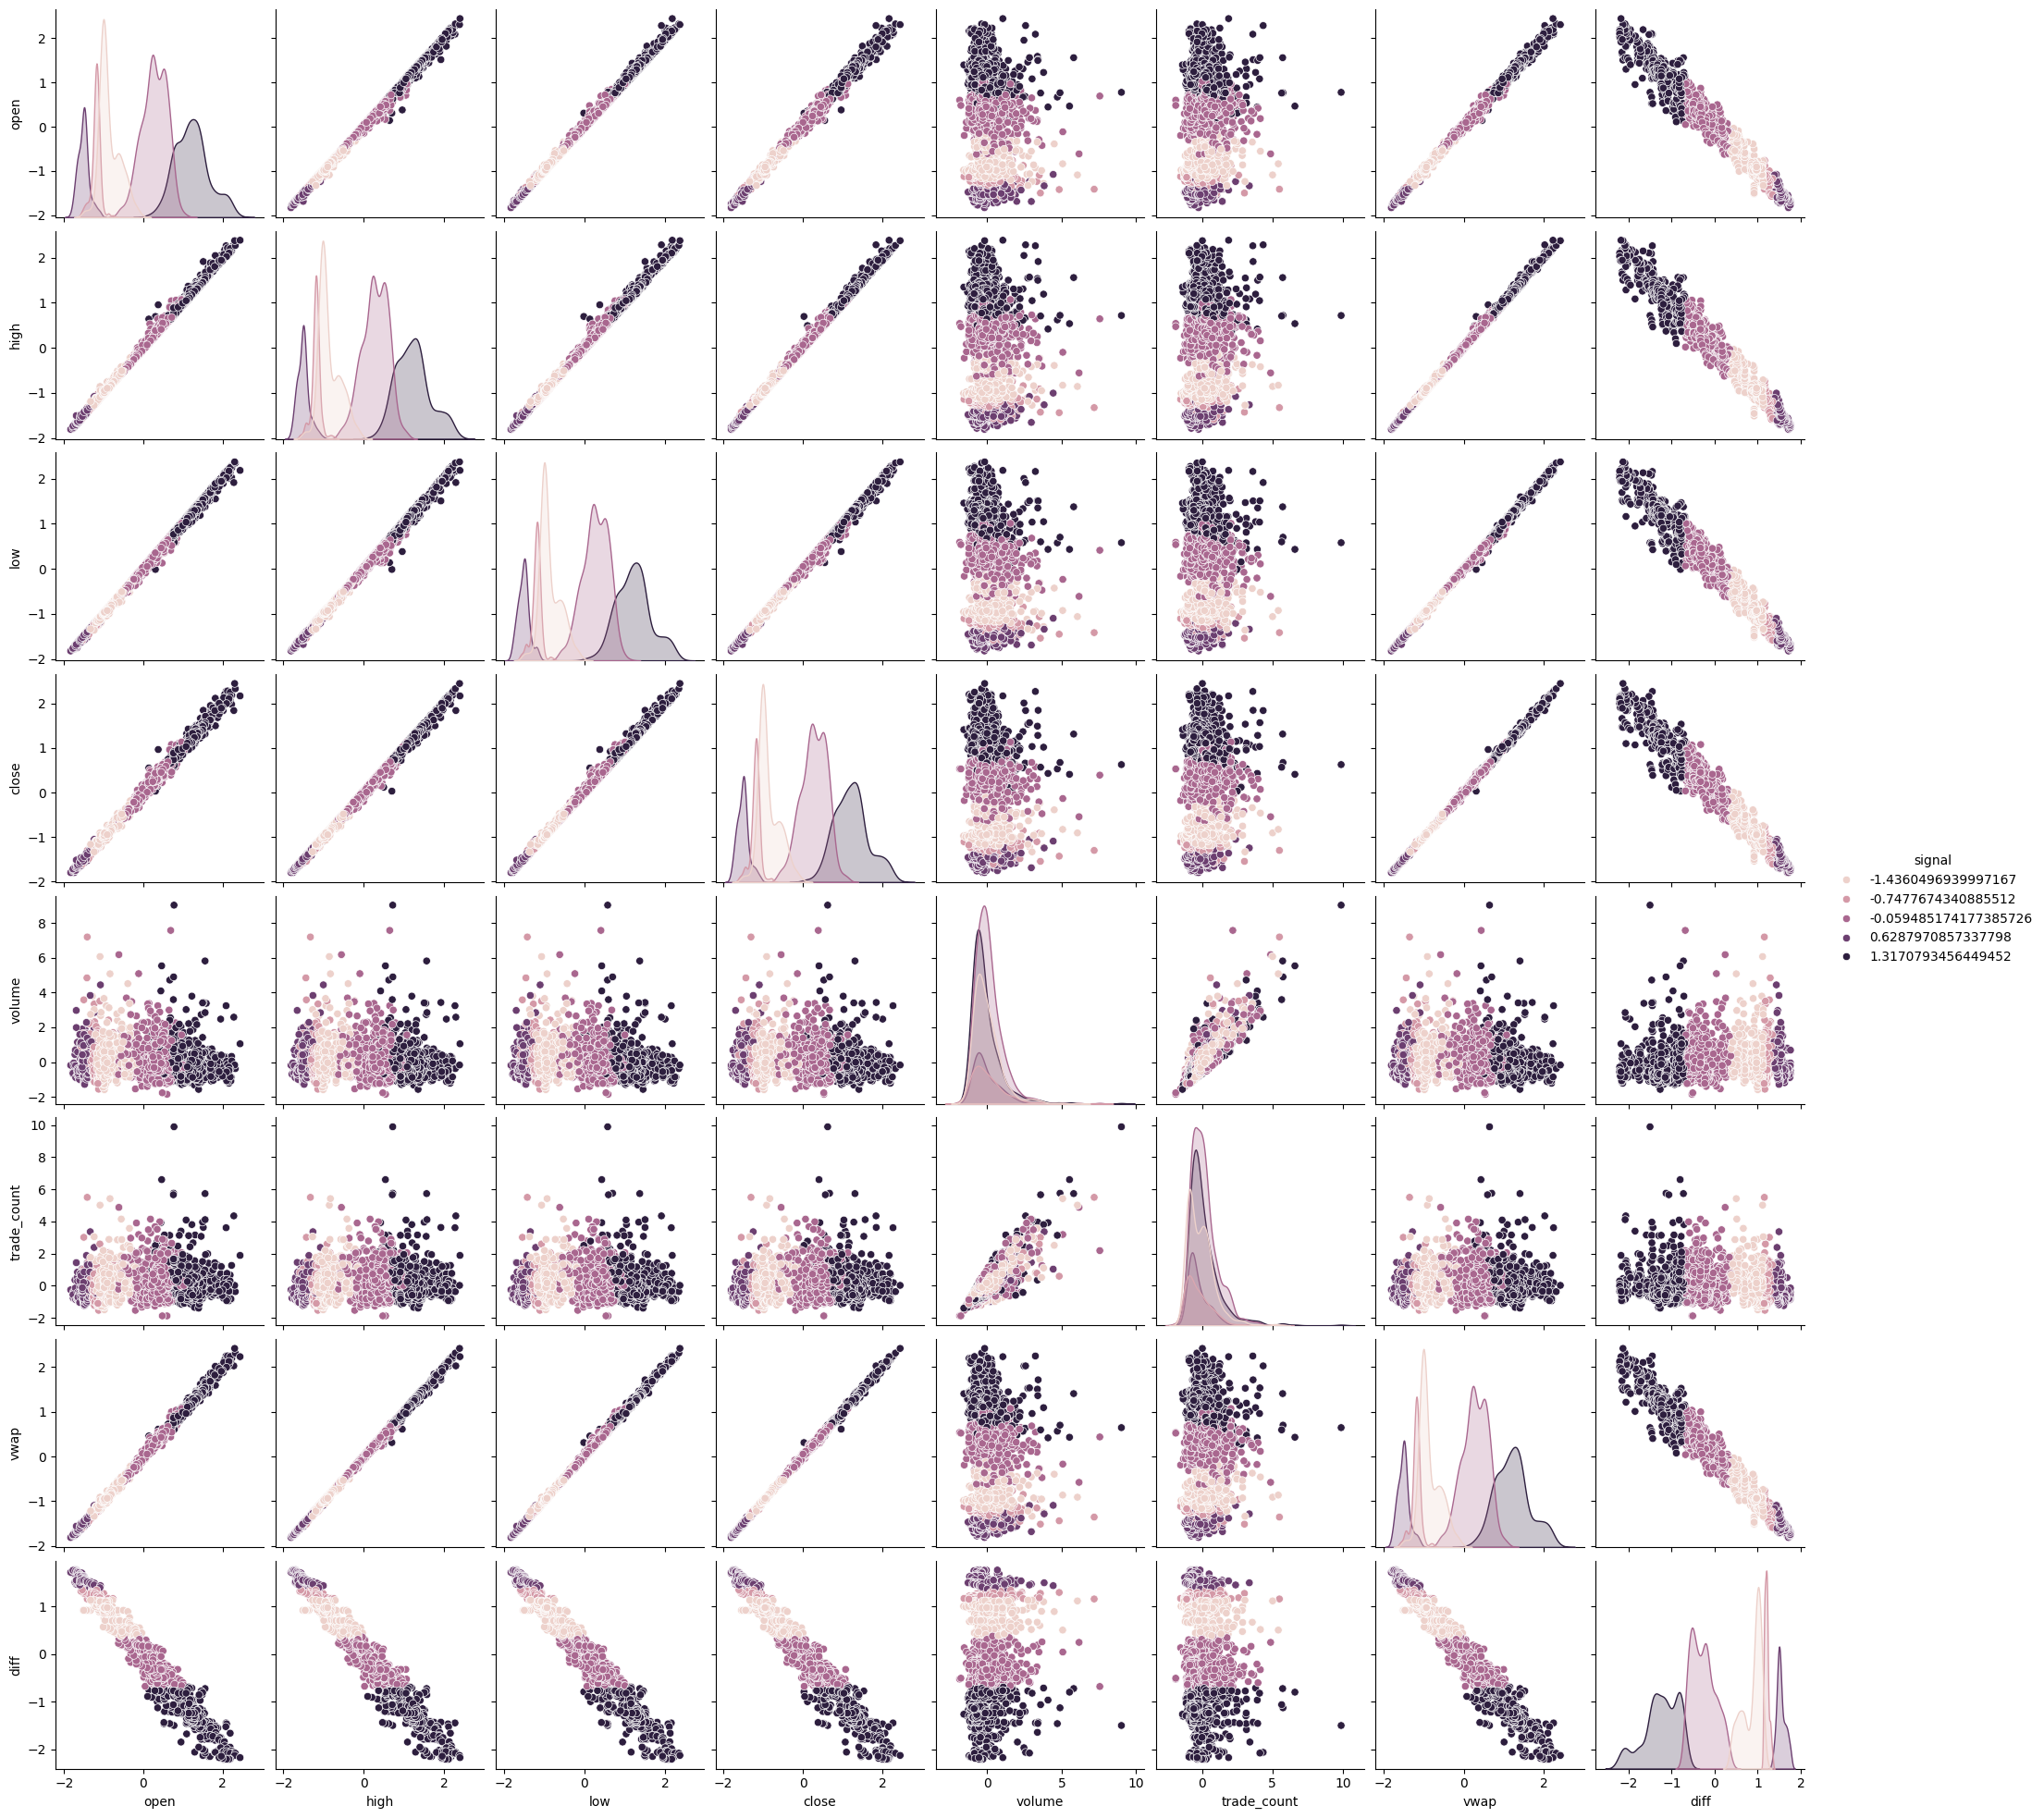

In [9]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler()

scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.keys())

sns.pairplot(scaled_data, hue="signal")

In [25]:
split_prc = 0.8
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

2129 1703 426


In [36]:
X_train = train_data.drop(columns=["signal", "diff"], inplace=False)
y_train = train_data["signal"]

print(X_train.shape, y_train.shape)

X_test = test_data.drop(columns=["signal", "diff"], inplace=False)
y_test = test_data["signal"]

print(X_test.shape, y_test.shape)
X_train.keys()

(1703, 7) (1703,)
(426, 7) (426,)


Index(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], dtype='object')

<Axes: xlabel='timestamp'>

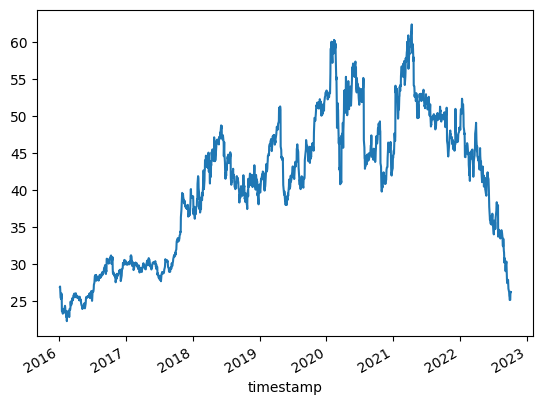

In [27]:
train_data["open"].plot()

In [42]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=7)
print(X_train.keys())
model = model.fit(X_train, y_train)

Index(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], dtype='object')


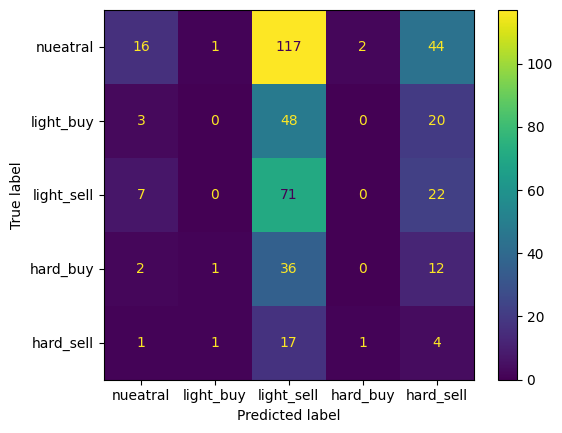

In [43]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(classes.keys()))
cmd.plot()

In [44]:

from numpy import ndarray
from pandas import DataFrame


class KNN_Strategy(cira.strategy.Strategy):
    def __init__(self, model:KNeighborsClassifier, scaler: StandardScaler) -> None:
        super().__init__(name="KNN")
        self.model = model
        self.allocation = list()
        self.scaler = scaler
        self.preds = []

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float) -> ndarray:
        X_scaled = self.scaler.transform(feature_data)
        pred = model.predict(X_scaled)[-1]
        self.preds.append(pred)
        max_al = (cash / prices.values[-1])[0]
        max_sell = (portfolio[-1] / prices.values[-1])[0]
        actions = {
            classes["nueatral"]: 0,
            classes["light_buy"]: max_al*0.01,
            classes["light_sell"]: -max_sell*0.2,
            classes["hard_buy"]: max_al*0.5,
            classes["hard_sell"]: -max_sell*0.8,
        }

        al = np.array([actions[pred]])
        #al = np.array([0])
        self.allocation.append(portfolio[-1])
        return al 

In [45]:
X_test.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-10-07 04:00:00+00:00,25.06,25.16,24.56,24.63,66008017.0,252337.0,24.78
2022-10-10 04:00:00+00:00,24.84,24.89,24.03,24.13,48488102.0,215231.0,24.27
2022-10-11 04:00:00+00:00,23.95,24.40,23.64,23.98,53291714.0,234816.0,23.97
2022-10-12 04:00:00+00:00,23.99,24.44,23.62,24.26,43684748.0,186046.0,24.20
2022-10-13 04:00:00+00:00,23.68,25.70,23.55,25.30,67514160.0,285294.0,24.93


In [46]:
strat = KNN_Strategy(model, scaler)
#X_backtest = test_data.drop(columns=["signal", "diff"], inplace=False)
bt = cira.strategy.multi_strategy_backtest([cira.strategy.ByAndHold(), cira.strategy.DollarCostAveraging(1), strat], X_test, X_test["open"].to_frame(), 10_000)
print(f"Delta: {bt[strat.name].values[-1] - bt['BuyAndHold'].values[-1]:.2f}$")
bt.plot()

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- diff
- signal
